In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import cv2 
import tensorflow as tf 
import os 
import seaborn as sns
import random

In [2]:
from PIL import Image
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout
from keras.layers import BatchNormalization
from keras import regularizers
from lazypredict.Supervised import LazyClassifier

In [3]:
os.chdir('C:/Users/mathl/Desktop/TrafficS')
data_path = os.getcwd()

In [4]:
classes = { 0:'Speed limit (20km/h)',
            1:'Speed limit (30km/h)', 
            2:'Speed limit (50km/h)', 
            3:'Speed limit (60km/h)', 
            4:'Speed limit (70km/h)', 
            5:'Speed limit (80km/h)', 
            6:'End of speed limit (80km/h)', 
            7:'Speed limit (100km/h)', 
            8:'Speed limit (120km/h)', 
            9:'No passing', 
            10:'No passing veh over 3.5 tons', 
            11:'Right-of-way at intersection', 
            12:'Priority road', 
            13:'Yield', 
            14:'Stop', 
            15:'No vehicles', 
            16:'Veh > 3.5 tons prohibited', 
            17:'No entry', 
            18:'General caution', 
            19:'Dangerous curve left', 
            20:'Dangerous curve right', 
            21:'Double curve', 
            22:'Bumpy road', 
            23:'Slippery road', 
            24:'Road narrows on the right', 
            25:'Road work', 
            26:'Traffic signals', 
            27:'Pedestrians', 
            28:'Children crossing', 
            29:'Bicycles crossing', 
            30:'Beware of ice/snow',
            31:'Wild animals crossing', 
            32:'End speed + passing limits', 
            33:'Turn right ahead', 
            34:'Turn left ahead', 
            35:'Ahead only', 
            36:'Go straight or right', 
            37:'Go straight or left', 
            38:'Keep right', 
            39:'Keep left', 
            40:'Roundabout mandatory', 
            41:'End of no passing', 
            42:'End no passing veh > 3.5 tons' }

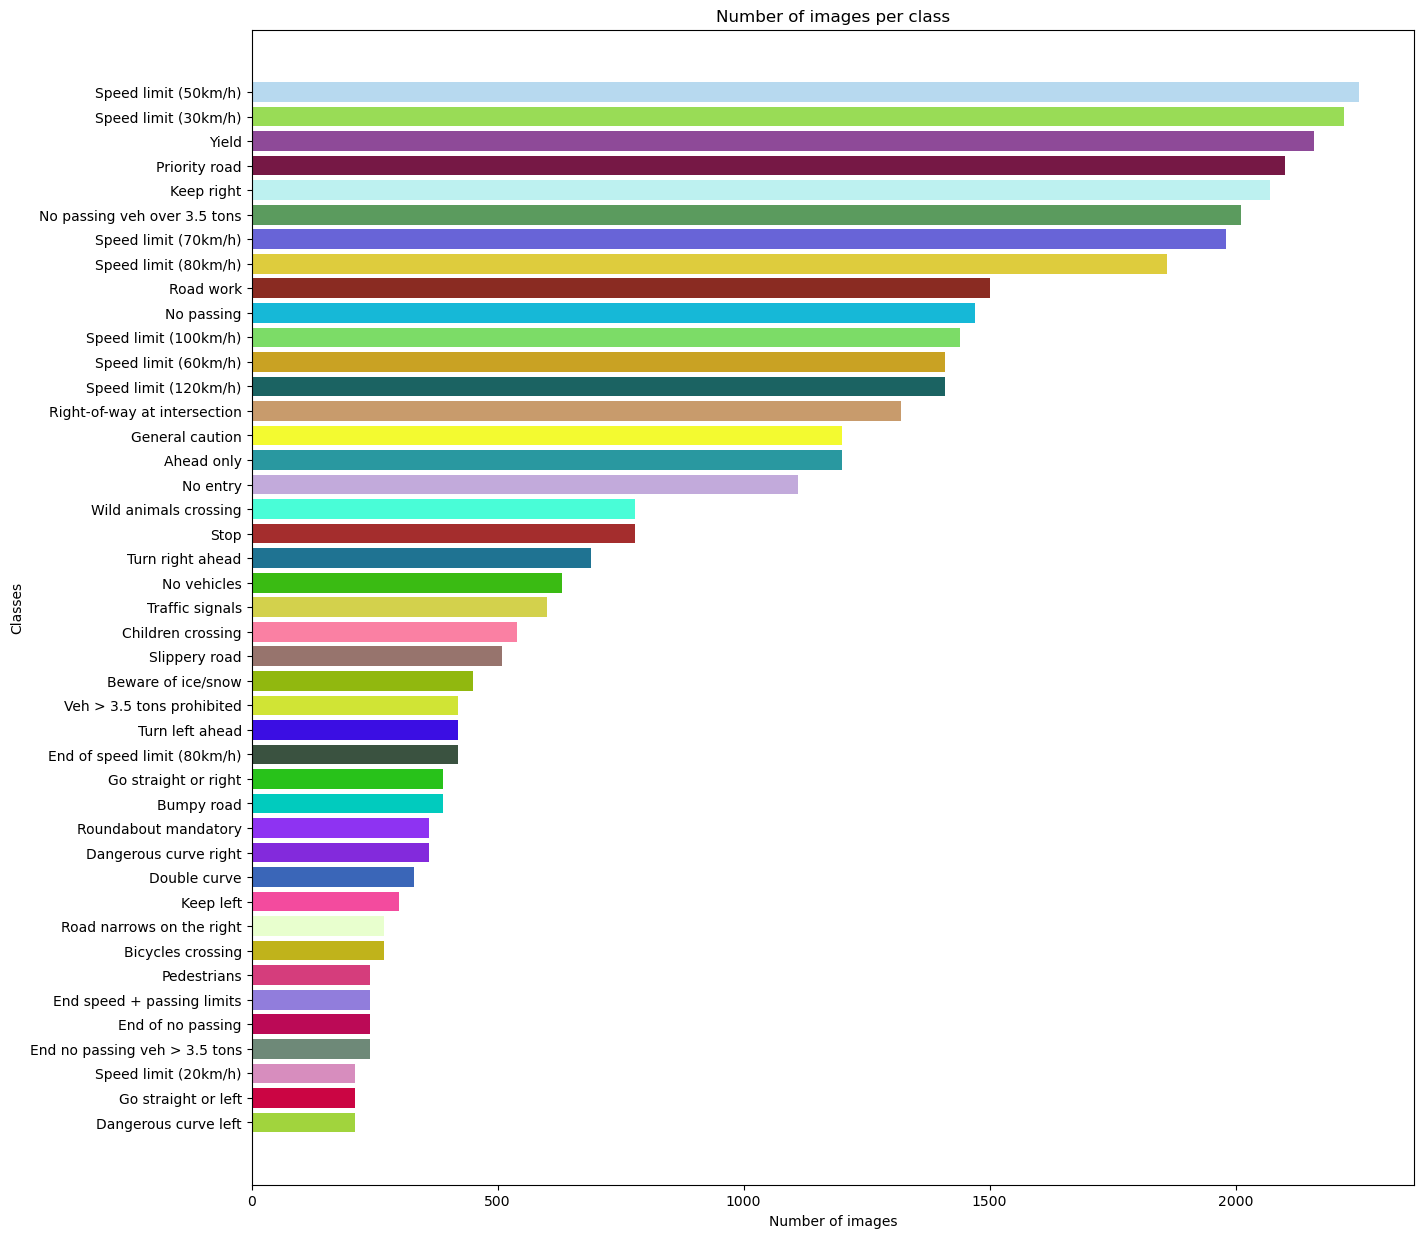

In [5]:
train_path = os.path.join(data_path, 'train')
folders = os.listdir(train_path)

train_number = []
class_num = []

for folder in folders:
    train_files = os.listdir(train_path + '/' + folder)
    train_number.append(len(train_files))
    class_num.append(classes[int(folder)])
    
# Sorting the dataset on the basis of number of images in each class
zipped_lists = zip(train_number, class_num)
sorted_pairs = sorted(zipped_lists)
tuples = zip(*sorted_pairs)
train_number, class_num = [ list(tuple) for tuple in  tuples]

# Plotting the number of images in each class
  
colors = []
for i in range(len(class_num)):
    colors.append('#' + ''.join([random.choice('0123456789ABCDEF') for j in range(6)]))

plt.figure(figsize=(15, 15))
plt.barh(class_num, train_number, color=colors)
plt.xlabel('Number of images')
plt.ylabel('Classes')
plt.title('Number of images per class')
plt.show()

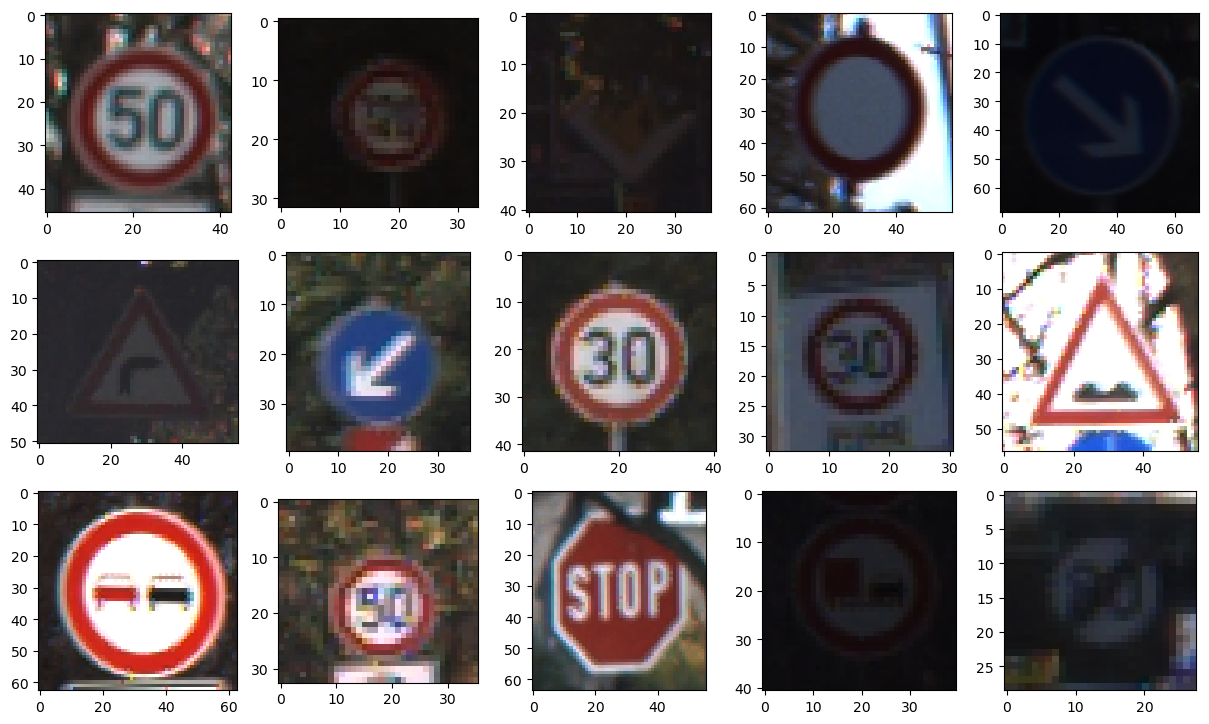

In [6]:
from matplotlib.image import imread
train = pd.read_csv(data_path + '/Train.csv')
imgs = train["Path"].values
plt.figure(figsize=(15,15))
plt.title("Some of Train images")
for i in range(1,16):
    plt.subplot(5,5,i)
    random_img_path = data_path + '/' + random.choice(imgs)
    rand_img = imread(random_img_path)
    plt.imshow(rand_img)

In [7]:
data = []
labels = []

In [8]:
import imgaug.augmenters as iaa

# Création de l'objet d'augmentation
augmenter = iaa.Sequential([
    iaa.Affine(rotate=(-10, 10)),  # Rotation aléatoire entre -10 et 10 degrés
    iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})  # Translation aléatoire
])

In [9]:
from PIL import Image


for i in range(len(folders)):
    path = os.path.join(data_path, 'train', str(i))
    images = os.listdir(path)
    for a in images:
        try:
            image = Image.open(path + '\\'+ a)
            image = image.resize((30, 30))
            image = np.array(image)
            data.append(image)
            labels.append(i)
             # Appliquer la data augmentation à l'image
            augmented_image = augmenter(image=image)
            
            data.append(augmented_image)
            labels.append(i)
           
        except:
            print("Error loading image")


In [10]:
data = np.array(data)
labels = np.array(labels)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2,shuffle = True, random_state=123)

In [12]:
y_train = to_categorical(y_train, 43)
y_test = to_categorical(y_test, 43)

In [13]:
model = Sequential()

# Bloc One
model.add(BatchNormalization(input_shape=X_train.shape[1:]))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.15))

# Bloc Two
model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters=256, kernel_size=(3,3), activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.2))

# Bloc Three
model.add(Conv2D(filters=512, kernel_size=(3,3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(rate=0.3))

model.add(Flatten())

# Dense Layers
model.add(Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)))
model.add(Dropout(rate=0.5))
model.add(Dense(43, activation='softmax'))

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 30, 30, 3)        12        
 ormalization)                                                   
                                                                 
 batch_normalization_1 (Batc  (None, 30, 30, 3)        12        
 hNormalization)                                                 
                                                                 
 conv2d (Conv2D)             (None, 28, 28, 32)        896       
                                                                 
 batch_normalization_2 (Batc  (None, 28, 28, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 64)        18496     
                                                        

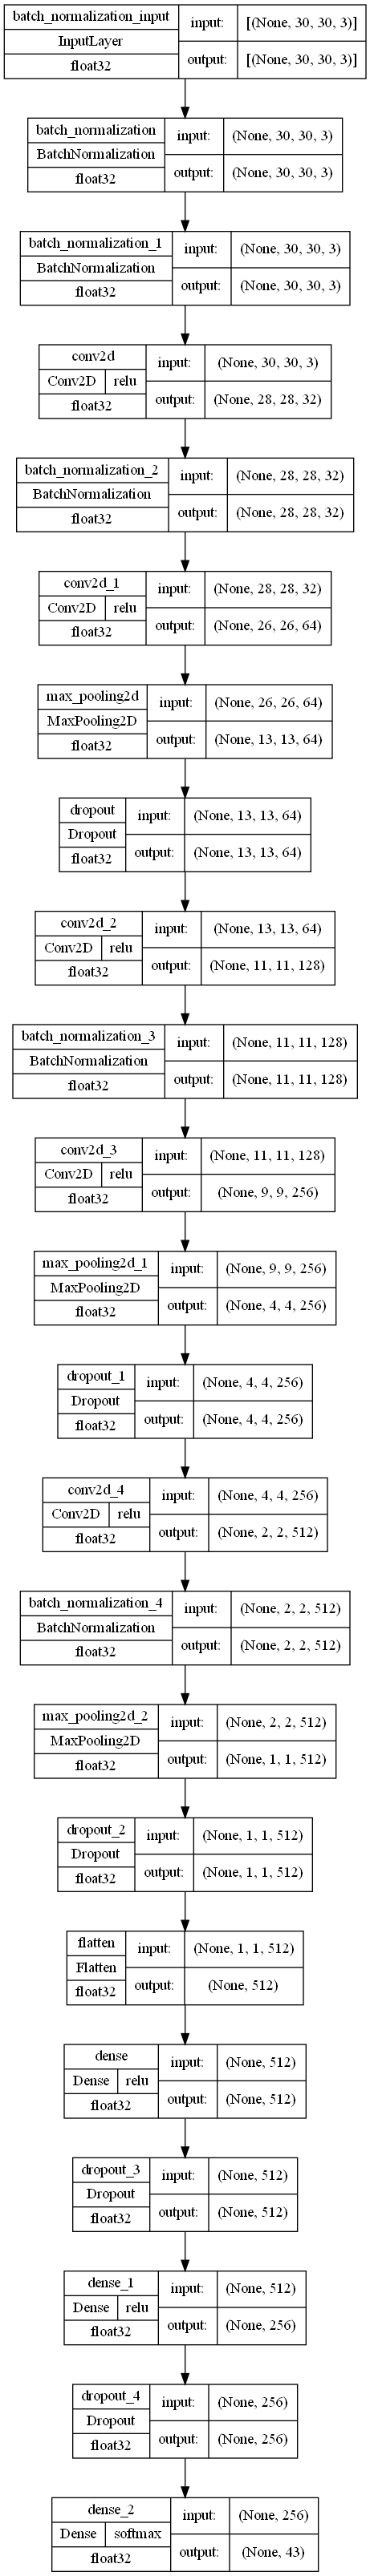

In [15]:
from tensorflow.keras.utils import plot_model
plot_model(model = model,\
          show_shapes=True,\
          show_dtype=True,\
          show_layer_names=True,\
          show_layer_activations=True)

In [16]:
from keras.optimizers import Adam
optimizer = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [17]:
history = model.fit(X_train, y_train, batch_size=32, epochs=25, validation_data=(X_test, y_test))

Epoch 1/25
1961/1961 [==============================] - 282s 143ms/step - loss: 2.3619 - accuracy: 0.7111 - val_loss: 0.5702 - val_accuracy: 0.9549
Epoch 2/25
1961/1961 [==============================] - 286s 146ms/step - loss: 0.5360 - accuracy: 0.9566 - val_loss: 0.4151 - val_accuracy: 0.9878
Epoch 3/25
1961/1961 [==============================] - 286s 146ms/step - loss: 0.4834 - accuracy: 0.9686 - val_loss: 0.3487 - val_accuracy: 0.9958
Epoch 4/25
1961/1961 [==============================] - 277s 141ms/step - loss: 0.5014 - accuracy: 0.9700 - val_loss: 0.3882 - val_accuracy: 0.9959
Epoch 5/25
1961/1961 [==============================] - 284s 145ms/step - loss: 0.4608 - accuracy: 0.9782 - val_loss: 0.3416 - val_accuracy: 0.9962
Epoch 6/25
1961/1961 [==============================] - 284s 145ms/step - loss: 0.4584 - accuracy: 0.9792 - val_loss: 0.5360 - val_accuracy: 0.9963
Epoch 7/25
1961/1961 [==============================] - 283s 144ms/step - loss: 0.4293 - accuracy: 0.9828 - val_

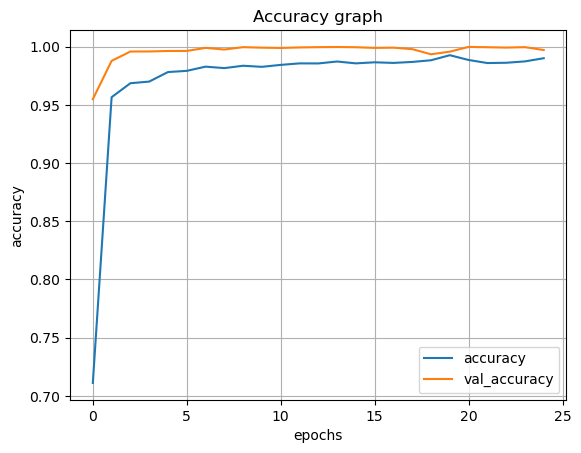

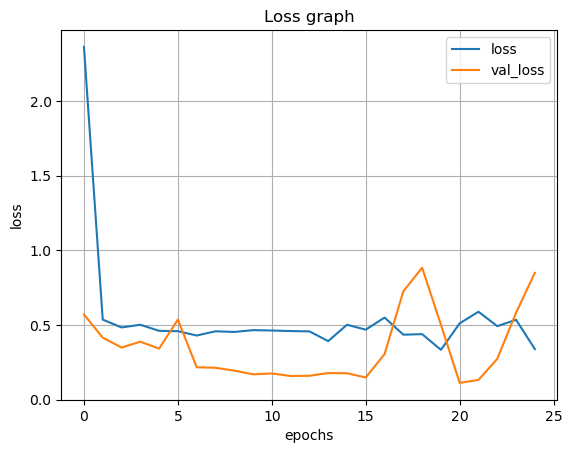

In [18]:
history_frame = pd.DataFrame(history.history)
#Accuracy graph
history_frame.loc[:, ['accuracy', 'val_accuracy']].plot()
plt.title('Accuracy graph')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.grid(True)
plt.show()
#Loss graph
history_frame.loc[:, ['loss', 'val_loss']].plot()
plt.title('Loss graph')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from sklearn.metrics import accuracy_score
y_test = pd.read_csv('test.csv')
label = y_test["ClassId"].values
imgs = y_test["Path"].values
data=[]
for img in imgs:
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
X_test=np.array(data)
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
y_pred

395/395 [==============================] - 6s 15ms/step


array([16,  1, 38, ...,  6,  7, 10], dtype=int64)

In [20]:
from sklearn.metrics import accuracy_score
print(accuracy_score(label, y_pred))

0.9820269200316706


In [21]:
from sklearn.metrics import confusion_matrix
cf = confusion_matrix(label, y_pred)

<AxesSubplot:>

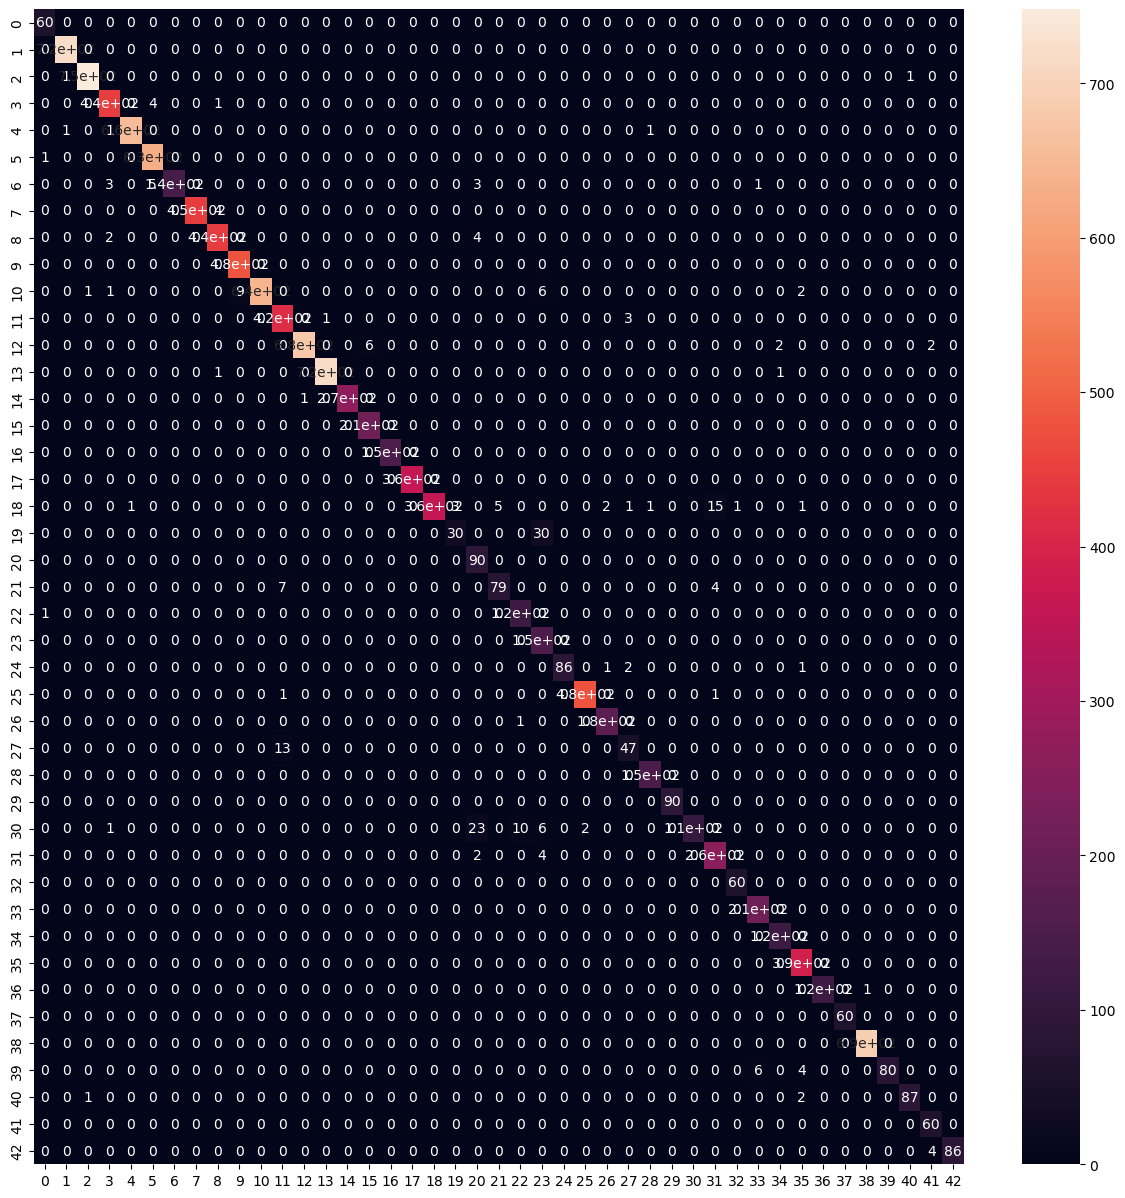

In [22]:
import seaborn as sns
df_cm = pd.DataFrame(cf, index = classes,  columns = classes)
plt.figure(figsize = (15,15))
sns.heatmap(df_cm, annot=True)

In [23]:
from sklearn.metrics import classification_report
print(classification_report(label, y_pred))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98        60
           1       1.00      1.00      1.00       720
           2       1.00      1.00      1.00       750
           3       0.98      0.99      0.99       450
           4       1.00      1.00      1.00       660
           5       0.99      1.00      0.99       630
           6       1.00      0.92      0.96       150
           7       1.00      0.99      1.00       450
           8       0.99      0.99      0.99       450
           9       0.98      1.00      0.99       480
          10       1.00      0.97      0.99       660
          11       0.95      0.99      0.97       420
          12       1.00      0.99      0.99       690
          13       1.00      1.00      1.00       720
          14       1.00      1.00      1.00       270
          15       0.97      1.00      0.99       210
          16       1.00      1.00      1.00       150
          17       1.00    

In [24]:
model.save("TSRR.h5")

In [25]:
def test_on_img(img):
    data=[]
    image = Image.open(img)
    image = image.resize((30,30))
    data.append(np.array(image))
    X_test=np.array(data)
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=1)
    y_pred
    return image,y_pred

1/1 [==============================] - 0s 18ms/step
Predicted traffic sign is:  Speed limit (100km/h)


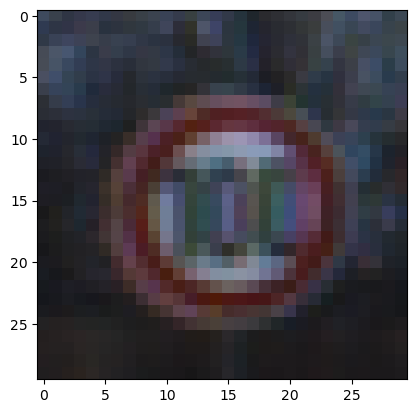

In [27]:
plot,prediction = test_on_img('C:/Users/mathl/Desktop/TrafficS/Test/01620.png')
s = [str(i) for i in prediction] 
a = int("".join(s)) 
print("Predicted traffic sign is: ", classes[a])
plt.imshow(plot)
plt.show()